In [35]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import os
import pandas as pd
import scipy.stats
import sys
import scipy.io
import datetime, time
import pandas as pd
sys.path.insert(1, '/glade/u/home/lettier/analysis/')
import master_utils as myf

## Make some plots of AMOC with monthly data

#### Open RAPID array data
I have not done any smoothing

In [36]:
rapid = xr.open_dataset('/glade/work/lettier/RAPID/moc_transports.nc').moc_mar_hc10 # this is daily, take monthly average
rapid_mon = rapid.resample(time='1M').mean('time')

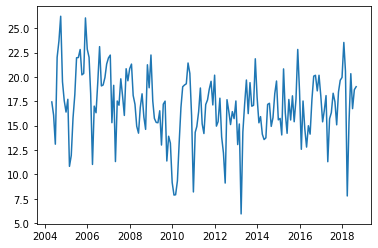

In [37]:
plt.plot(rapid_mon.time, rapid_mon)

#### Open Frajka Williams (2015) MOC reconstruction
Note that this has been filtered (Tukey smoothing?) and I don't know how to do this to the model output (or the RAPID array)

In [38]:
mat = scipy.io.loadmat('/glade/work/lettier/RAPID/reconFrajkaWilliams/MOCproxy_for_figshare_v1.0.mat')

In [39]:
def matlab2datetime(matlab_datenum): #turn Matlab time into Python time
    
    if matlab_datenum!=matlab_datenum: #if there is NaN in the time dimension
        mytime = 0 # this sets time to 1970, which we will then screen out below
    else:
        day = datetime.datetime.fromordinal(int(matlab_datenum))
        dayfrac = datetime.timedelta(days=matlab_datenum%1) - datetime.timedelta(days=366)
        mytime = day + dayfrac
    return mytime

In [40]:
mydict = {}
mydict['time'] = mat['recon']['time'][0][0][0]
mydict['recon'] = mat['recon']['mocproxy'][0][0][0]
recon = pd.DataFrame(mydict)
recon['time'] = [matlab2datetime(tval) for tval in recon['time']]
recon['time'] = np.array(recon['time'],dtype='datetime64[s]')

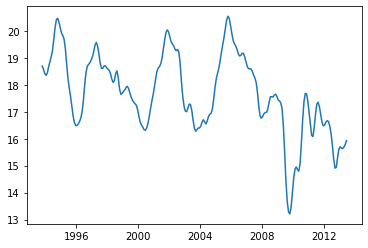

In [41]:
plt.plot(recon['time'], recon['recon'])

#### Open model output
The files I read in here were created in 0_process_moc.ipynb
They are the maximum of the total overturning streamfunction between 500 and 2000 m

In [42]:
mydir = '/glade/work/lettier/NUDGE/processed/moc/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir)) if '.nc' in f and 'monthly' in f ]

listds = []
for f in myfiles:
    ds = xr.open_dataset(f)
    ds = ds.set_coords('names')
    listds.append(ds)
ds = xr.concat(listds,dim='names')

Set some properties for plotting

In [43]:
mylist = []
for f in ds.names.values:
    if 'LENS' in f:
        mylist.append({'label' : 'LENS', 'c' : 'tab:blue', 'linewidth' : .25, 'alpha' : .3})
    elif 'era_60' in f:
        mylist.append({'label' : 'NUDGE-anom-60', 'c' : 'tab:green', 'linewidth' : 1.5, 'alpha' : 1.})
    elif 'SH' in f:
        mylist.append({'label' : 'NUDGE-SH', 'c' : 'tab:cyan', 'linewidth' : 1.5, 'alpha' : 1.})

    elif 'anom' in f:
        mylist.append({'label' : 'NUDGE-anom', 'c' : 'orange', 'linewidth' : 1.5, 'alpha' : 1.})
    else:
        mylist.append({'label' : 'NUDGE', 'c' : 'tab:red', 'linewidth' : 1.5, 'alpha' : 1.})
  
df = pd.DataFrame(mylist, index = ds.names.values) 
df = df.transpose()

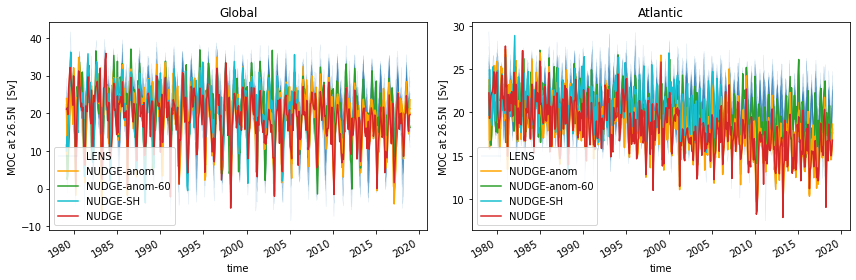

In [44]:
fig = plt.figure(figsize=(12,4))
for r in range(2):
    ax = plt.subplot(1,2,r+1)
    
    for n, name in enumerate(ds.names.values):
        ds.isel(names=n).isel(transport_reg=r).MOC.interp(lat_aux_grid=26.5).plot(ax=ax, **df[name].to_dict())     

    ax.set_title(['Global','Atlantic'][r])
    ax.legend()
    ax.set_ylabel('MOC at 26.5N  [Sv]')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    
plt.tight_layout()
plt.show(); plt.close()

#### Plot model and observations together, with 12 month smoothing

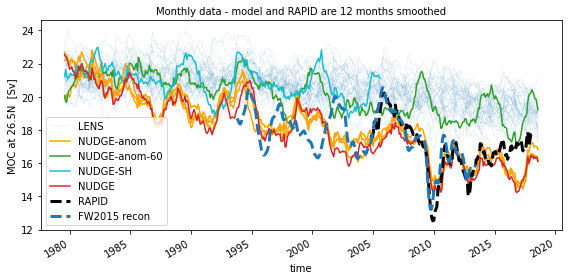

In [58]:
fig = plt.figure(figsize=(8,4))

smooth = 12
ax = plt.subplot(1,1,1)
for n, name in enumerate(ds.names.values):
        ds.sel(names=name).isel(transport_reg=1).MOC.interp(lat_aux_grid=26.5).rolling(time=smooth, center=True).mean().plot(ax=ax, **df[name].to_dict()) 
rapid_mon.rolling(time=smooth, center=True).mean().plot(ax=ax,label='RAPID',c='k',linewidth=3, linestyle='--')
ax.plot(recon['time'], recon['recon'],linestyle='--',linewidth=3,label='FW2015 recon')

ax.set_title('Monthly data - model and RAPID are '+str(smooth)+' months smoothed',fontsize=10)
ax.set_ylabel('MOC at 26.5N  [Sv]')   
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout()
fig.savefig('moc_26.5N_timeseries_1979-2018.png', bbox_inches='tight')
plt.show(); plt.close()

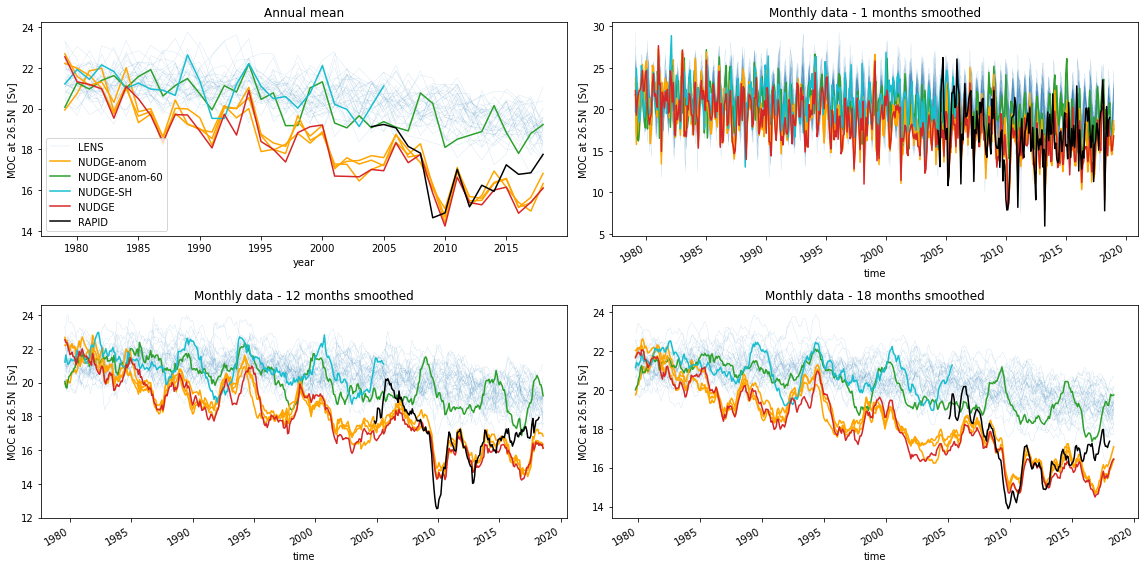

In [46]:
fig = plt.figure(figsize=(16,8))

ax = plt.subplot(2,2,1)
for n, name in enumerate(ds.names.values):
    ds.isel(names=n).isel(transport_reg=r).MOC.interp(lat_aux_grid=26.5).groupby('time.year').mean(dim='time').plot(ax=ax, **df[name].to_dict())     
rapid_mon.groupby('time.year').mean(dim='time').plot(ax=ax,label='RAPID',c='k',linewidth=1.5)
ax.set_title('Annual mean')
ax.set_ylabel('MOC at 26.5N  [Sv]')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())


for s, smooth in enumerate([1,12,18]):
    ax = plt.subplot(2,2,2+s)
    for n, name in enumerate(ds.names.values):
        ds.isel(names=n).isel(transport_reg=r).MOC.interp(lat_aux_grid=26.5).rolling(time=smooth, center=True).mean().plot(ax=ax, **df[name].to_dict())     
    rapid_mon.rolling(time=smooth, center=True).mean().plot(ax=ax,label='RAPID',c='k',linewidth=1.5)
    ax.set_title('Monthly data - '+str(smooth)+' months smoothed')
    ax.set_ylabel('MOC at 26.5N  [Sv]')   
plt.tight_layout()
#fig.savefig('amocfigs/moc_26.5N_timeseries_1979-2018.png', bbox_inches='tight')
plt.show(); plt.close()

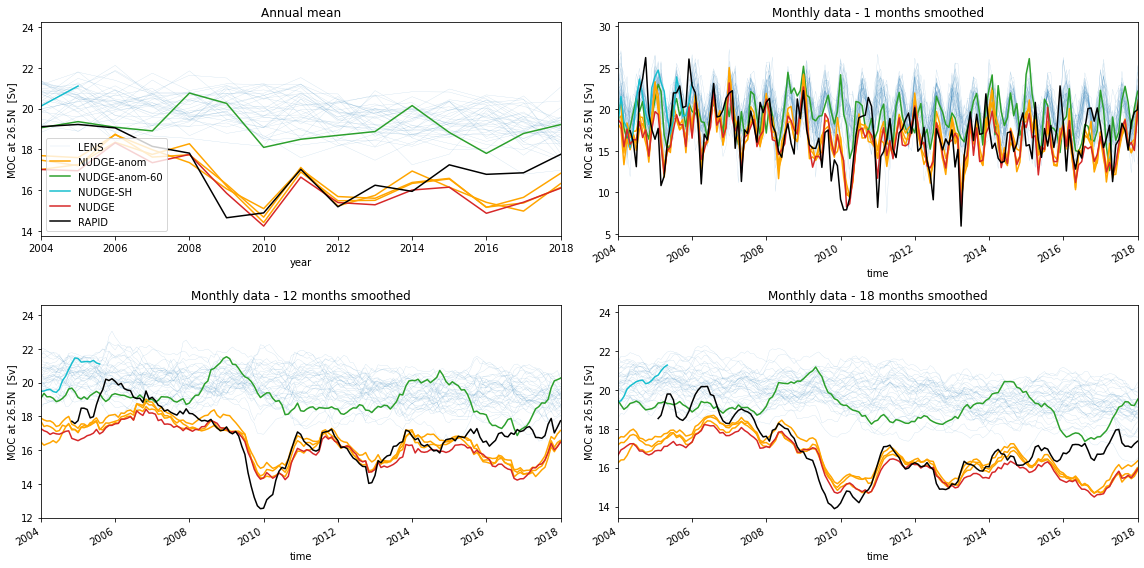

In [48]:
fig = plt.figure(figsize=(16,8))

ax = plt.subplot(2,2,1)
for n, name in enumerate(ds.names.values):
    ds.isel(names=n).isel(transport_reg=r).MOC.interp(lat_aux_grid=26.5).groupby('time.year').mean(dim='time').plot(ax=ax, **df[name].to_dict())     
rapid_mon.groupby('time.year').mean(dim='time').plot(ax=ax,label='RAPID',c='k',linewidth=1.5)
ax.set_title('Annual mean')
ax.set_ylabel('MOC at 26.5N  [Sv]')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
ax.set_xlim([2004,2018])


for s, smooth in enumerate([1,12,18]):
    ax = plt.subplot(2,2,2+s)
    for n, name in enumerate(ds.names.values):
        ds.isel(names=n).isel(transport_reg=r).MOC.interp(lat_aux_grid=26.5).rolling(time=smooth, center=True).mean().plot(ax=ax, **df[name].to_dict())     
    rapid_mon.rolling(time=smooth, center=True).mean().plot(ax=ax,label='RAPID',c='k',linewidth=1.5)
    ax.set_title('Monthly data - '+str(smooth)+' months smoothed')
    ax.set_ylabel('MOC at 26.5N  [Sv]')   
    ax.set_xlim(['2004','2018'])
plt.tight_layout()
#fig.savefig('amocfigs/moc_26.5N_timeseries_2004-2018.png', bbox_inches='tight')
plt.show(); plt.close()

In [49]:
mynames = ['LENS01', 'LENS02', 'LENS03', 'LENS04', 'LENS05', 'LENS06',
       'LENS07', 'LENS08', 'LENS09', 'LENS10', 'LENS11', 'LENS12',
       'LENS13', 'LENS14', 'LENS15', 'LENS16', 'LENS17', 'LENS18',
       'LENS19', 'LENS20', 'LENS21', 'LENS22', 'LENS23', 'LENS24',
       'LENS25', 'LENS26', 'LENS27', 'LENS28', 'LENS29', 'LENS30',
       'LENS31', 'LENS32', 'LENS33', 'LENS34', 'LENS35', 'anom_nudge_era_60','anom_nudge_era',
       'anom_nudge_era_high', 'anom_nudge_era_low', 'nudge_era_high']

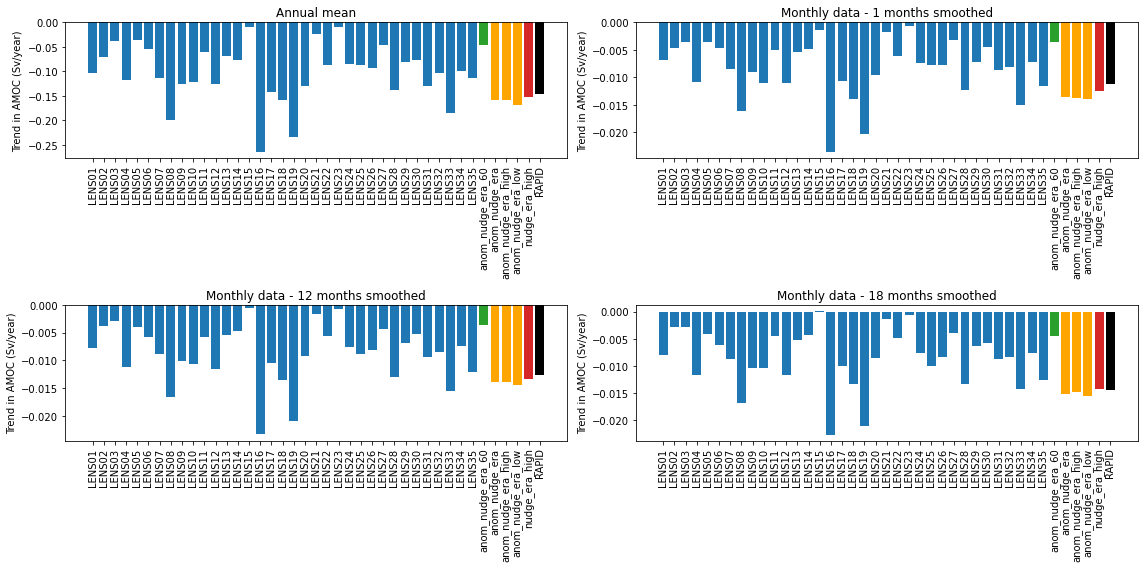

In [50]:
fig = plt.figure(figsize=(16,8))

ax = plt.subplot(2,2,1)
xdata = rapid_mon.groupby('time.year').mean(dim='time')
slope,_,_,_,_ = myf.linregress(np.arange(len(xdata.year)),xdata.load(),dim='year')
ax.bar(len(mynames),slope, facecolor = 'k')
   
for n, name in enumerate(mynames):
        ydata = ds.sel(names=name).isel(transport_reg=1).MOC.interp(lat_aux_grid=26.5).groupby('time.year').mean(dim='time') 
        ydata = ydata.where(ydata.year==xdata.year,drop=True)
        slope,_,_,_,_ = myf.linregress(np.arange(len(ydata.year)),ydata.load(),dim='year')
        ax.bar(n,slope, facecolor = df[name]['c'])

ax.set_xticks(np.arange(len(mynames)+1))
ax.set_xticklabels(mynames+['RAPID'],rotation='vertical')
ax.set_ylabel('Trend in AMOC (Sv/year)')
ax.set_title('Annual mean')


for s, smooth in enumerate([1,12,18]):
    ax = plt.subplot(2,2,2+s)
    xdata = rapid_mon.rolling(time=smooth, center=True).mean()
    slope,_,_,_,_ = myf.linregress(np.arange(len(xdata.time)),xdata.load(),dim='time')
    ax.bar(len(mynames),slope, facecolor = 'k')
              
    for n, name in enumerate(mynames):
        
            ydata = ds.sel(names=name).isel(transport_reg=1).MOC.interp(lat_aux_grid=26.5).rolling(time=smooth, center=True).mean()  
            ydata = ydata.where(ydata.time==xdata.time,drop=True)
            slope,_,_,_,_ = myf.linregress(np.arange(len(ydata.time)),ydata.load(),dim='time')
            ax.bar(n,slope, facecolor = df[name]['c'])
            
    ax.set_xticks(np.arange(len(mynames)+1))
    ax.set_xticklabels(mynames+['RAPID'],rotation='vertical')
    ax.set_ylabel('Trend in AMOC (Sv/year)')
    ax.set_title('Monthly data - '+str(smooth)+' months smoothed')
plt.tight_layout()
plt.show()
#fig.savefig('amocfigs/moc_26.5N_trend_2004-2018.png', bbox_inches='tight')
plt.close()

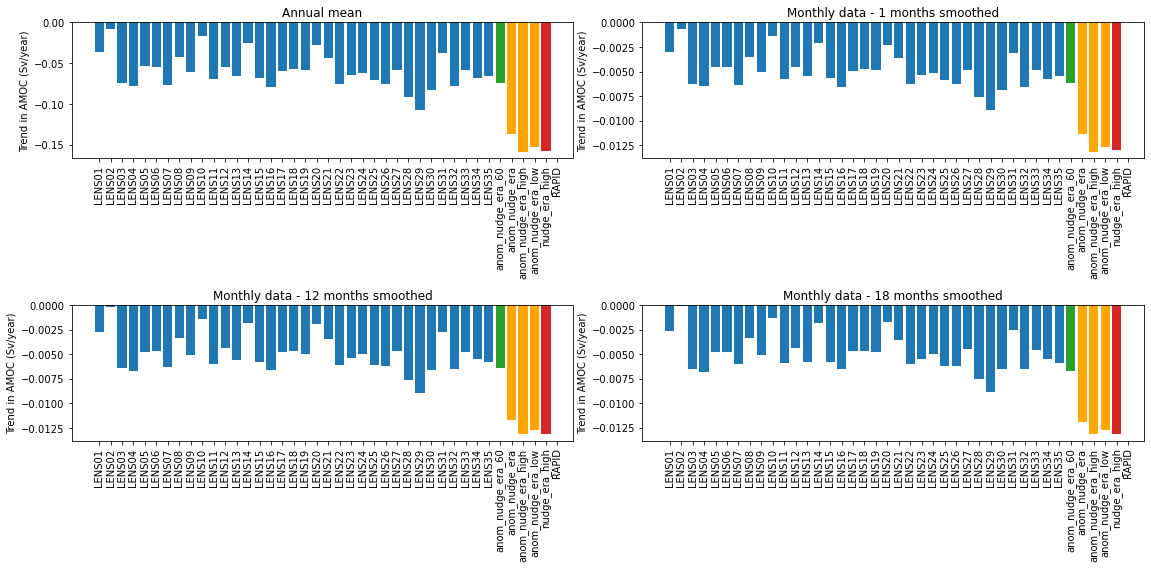

In [51]:
fig = plt.figure(figsize=(16,8))

ax = plt.subplot(2,2,1)
   
for n, name in enumerate(mynames):
        ydata = ds.sel(names=name).isel(transport_reg=1).MOC.interp(lat_aux_grid=26.5).groupby('time.year').mean(dim='time') 
        slope,_,_,_,_ = myf.linregress(np.arange(len(ydata.year)),ydata.load(),dim='year')
        ax.bar(n,slope, facecolor = df[name]['c'])

ax.set_xticks(np.arange(len(mynames)+1))
ax.set_xticklabels(mynames+['RAPID'],rotation='vertical')
ax.set_ylabel('Trend in AMOC (Sv/year)')
ax.set_title('Annual mean')


for s, smooth in enumerate([1,12,18]):
    ax = plt.subplot(2,2,2+s)
                
    for n, name in enumerate(mynames):
        
            ydata = ds.sel(names=name).isel(transport_reg=1).MOC.interp(lat_aux_grid=26.5).rolling(time=smooth, center=True).mean()  
            slope,_,_,_,_ = myf.linregress(np.arange(len(ydata.time)),ydata.load(),dim='time')
            ax.bar(n,slope, facecolor = df[name]['c'])
            
    ax.set_xticks(np.arange(len(mynames)+1))
    ax.set_xticklabels(mynames+['RAPID'],rotation='vertical')
    ax.set_ylabel('Trend in AMOC (Sv/year)')
    ax.set_title('Monthly data - '+str(smooth)+' months smoothed')
plt.tight_layout()
plt.show()
#fig.savefig('amocfigs/moc_26.5N_trend_1979-2018.png', bbox_inches='tight')
plt.close()

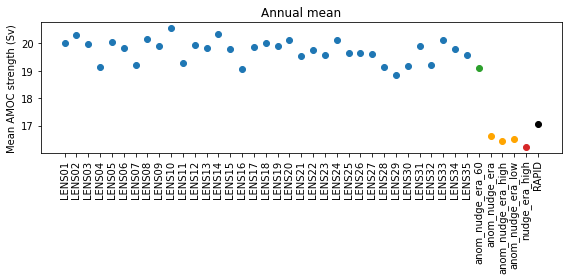

In [52]:
fig = plt.figure(figsize=(8,4))

ax = plt.subplot(1,1,1)
xdata = rapid_mon.groupby('time.year').mean(dim='time')
ax.scatter(len(mynames),xdata.mean(dim='year'), facecolor = 'k')

for n, name in enumerate(mynames):
        ydata = ds.sel(names=name).isel(transport_reg=1).MOC.interp(lat_aux_grid=26.5).groupby('time.year').mean(dim='time') 
        ydata = ydata.where(ydata.year==xdata.year,drop=True)
        ax.scatter(n,ydata.mean(dim='year'), facecolor = df[name]['c'])
        
ax.set_xticks(np.arange(len(mynames)+1))
ax.set_xticklabels(mynames+['RAPID'],rotation='vertical')
ax.set_ylabel('Mean AMOC strength (Sv)')
ax.set_title('Annual mean')


plt.tight_layout()
plt.show()
#fig.savefig('amocfigs/moc_26.5N_meanstrength_2004-2018.png', bbox_inches='tight')
plt.close()

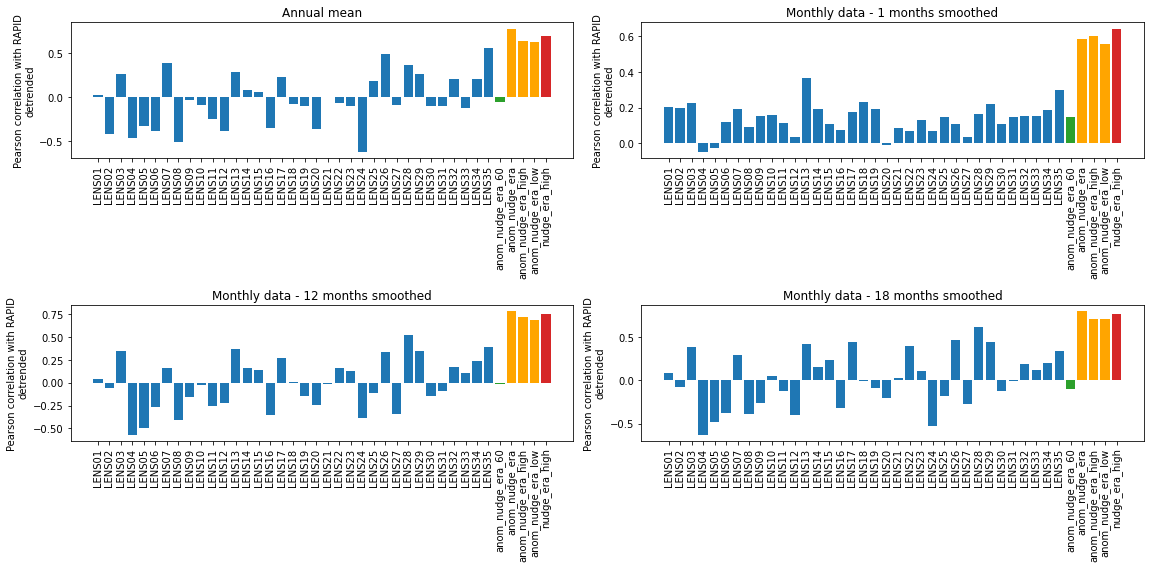

In [53]:
fig = plt.figure(figsize=(16,8))

ax = plt.subplot(2,2,1)
xdata = rapid_mon.groupby('time.year').mean(dim='time')
slope,_,_,_,_ = myf.linregress(np.arange(len(xdata.year)),xdata.load(),dim='year')
xdata = xdata - slope*xdata.year

for n, name in enumerate(mynames):
        ydata = ds.sel(names=name).isel(transport_reg=1).MOC.interp(lat_aux_grid=26.5).groupby('time.year').mean(dim='time') 
        ydata = ydata.where(ydata.year==xdata.year,drop=True)
        slope,_,_,_,_ = myf.linregress(np.arange(len(ydata.year)),ydata.load(),dim='year')
        ydata = ydata - slope*ydata.year
        corr, _ = myf.pearson(xdata,ydata,dim='year')

        ax.bar(n,corr, facecolor = df[name]['c'])
ax.set_xticks(np.arange(len(mynames)))
ax.set_xticklabels(mynames,rotation='vertical')
ax.set_ylabel('Pearson correlation with RAPID\ndetrended')
ax.set_title('Annual mean')


for s, smooth in enumerate([1,12,18]):
    ax = plt.subplot(2,2,2+s)
    
    xdata = rapid_mon.rolling(time=smooth, center=True).mean()
    slope,_,_,_,_ = myf.linregress(np.arange(len(xdata.time)),xdata.load(),dim='time')
    xdata = xdata - slope*xr.DataArray(np.arange(len(xdata)), coords={'time':xdata.time},dims=('time'))
    
    for n, name in enumerate(mynames):
            ydata = ds.sel(names=name).isel(transport_reg=1).MOC.interp(lat_aux_grid=26.5).rolling(time=smooth, center=True).mean()  

            ydata = ydata.where(ydata.time==xdata.time,drop=True)
            slope,_,_,_,_ = myf.linregress(np.arange(len(ydata.time)),ydata.load(),dim='time')
            ydata = ydata - slope*xr.DataArray(np.arange(len(ydata)), coords={'time':ydata.time},dims=('time'))
            corr, _ = myf.pearson(xdata,ydata,dim='time')

            ax.bar(n,corr, facecolor = df[name]['c'])
    ax.set_xticks(np.arange(len(mynames)))
    ax.set_xticklabels(mynames,rotation='vertical')
    ax.set_ylabel('Pearson correlation with RAPID\ndetrended')
    ax.set_title('Monthly data - '+str(smooth)+' months smoothed')
plt.tight_layout()
plt.show()
#fig.savefig('amocfigs/moc_26.5N_rapidcorr_2004-2018.png', bbox_inches='tight')
plt.close()

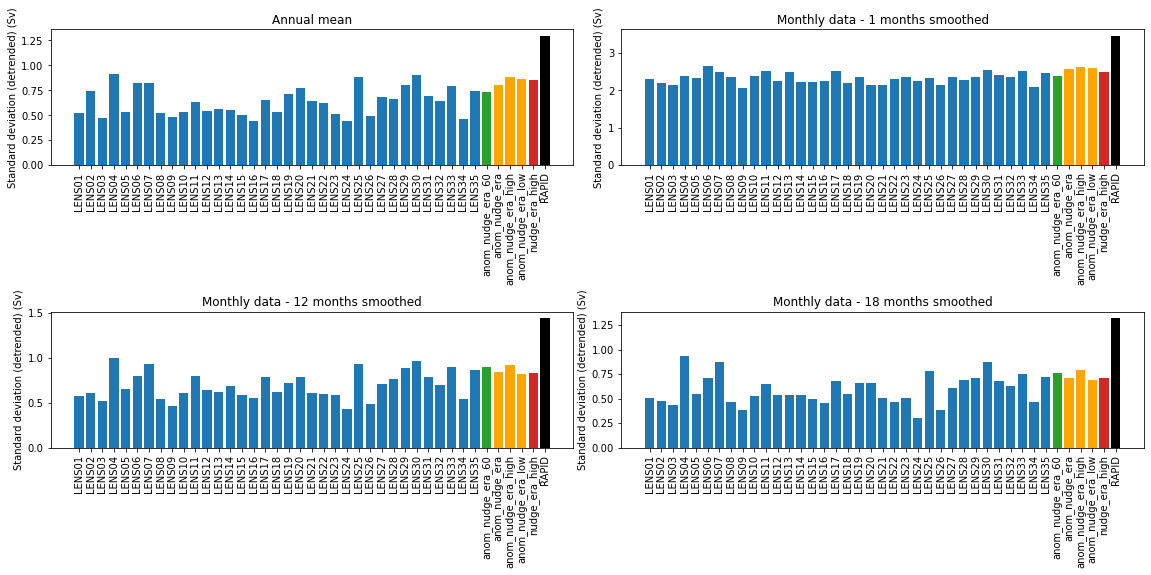

In [54]:
fig = plt.figure(figsize=(16,8))

ax = plt.subplot(2,2,1)
xdata = rapid_mon.groupby('time.year').mean(dim='time')
slope,_,_,_,_ = myf.linregress(np.arange(len(xdata.year)),xdata.load(),dim='year')
xdata = xdata - slope*xdata.year
ax.bar(len(mynames),xdata.std(dim='year'), facecolor='k')
        
for n, name in enumerate(mynames):
        ydata = ds.sel(names=name).isel(transport_reg=1).MOC.interp(lat_aux_grid=26.5).groupby('time.year').mean(dim='time') 
        ydata = ydata.where(ydata.year==xdata.year,drop=True)
        slope,_,_,_,_ = myf.linregress(np.arange(len(ydata.year)),ydata.load(),dim='year')
        ydata = ydata - slope*ydata.year
        corr, _ = myf.pearson(xdata,ydata,dim='year')

        ax.bar(n,ydata.std(dim='year'), facecolor = df[name]['c'])
        
ax.set_xticks(np.arange(len(mynames)+1))
ax.set_xticklabels(mynames+['RAPID'],rotation='vertical')
ax.set_ylabel('Standard deviation (detrended) (Sv)')
ax.set_title('Annual mean')


for s, smooth in enumerate([1,12,18]):
    ax = plt.subplot(2,2,2+s)
    
    xdata = rapid_mon.rolling(time=smooth, center=True).mean()
    slope,_,_,_,_ = myf.linregress(np.arange(len(xdata.time)),xdata.load(),dim='time')
    xdata = xdata - slope*xr.DataArray(np.arange(len(xdata)), coords={'time':xdata.time},dims=('time'))
    ax.bar(len(mynames),xdata.std(dim='time'), facecolor = 'k')

    for n, name in enumerate(mynames):
            ydata = ds.sel(names=name).isel(transport_reg=1).MOC.interp(lat_aux_grid=26.5).rolling(time=smooth, center=True).mean()  

            ydata = ydata.where(ydata.time==xdata.time,drop=True)
            slope,_,_,_,_ = myf.linregress(np.arange(len(ydata.time)),ydata.load(),dim='time')
            ydata = ydata - slope*xr.DataArray(np.arange(len(ydata)), coords={'time':ydata.time},dims=('time'))
            corr, _ = myf.pearson(xdata,ydata,dim='time')
            ax.bar(n,ydata.std(dim='time'), facecolor = df[name]['c'])
            
    ax.set_xticks(np.arange(len(mynames)+1))
    ax.set_xticklabels(mynames+['RAPID'],rotation='vertical')
    ax.set_ylabel('Standard deviation (detrended) (Sv)')
    ax.set_title('Monthly data - '+str(smooth)+' months smoothed')
plt.tight_layout()
plt.show()
#fig.savefig('amocfigs/moc_26.5N_stddev_2004-2018.png', bbox_inches='tight')
plt.close()